In [ ]:
! wget http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz

--2021-12-31 19:49:31--  http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740306953 (706M) [application/x-gzip]
Saving to: ‘UCSD_Anomaly_Dataset.tar.gz’

UCSD_Anomaly_Datase 100%[===================>] 706.01M  52.0MB/s    in 15s     

2021-12-31 19:49:47 (45.6 MB/s) - ‘UCSD_Anomaly_Dataset.tar.gz’ saved [740306953/740306953]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import mkdir

mkdir("/content/Dataset/")
mkdir("/content/Dataset/UCSD/")

In [ ]:
!tar -xzf "/content/UCSD_Anomaly_Dataset.tar.gz" -C "/content/Dataset/UCSD" 

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
from os import listdir, mkdir, remove
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [ ]:
class ModelConfig:
    TRAIN_DATASET_PATH ="/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
    TEST_DATASET_PATH = "/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
    SINGLE_TEST_PATH = "/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test036"
    BATCH_SIZE = 1
    EPOCHS = 10
    MODEL_WEIGHTS_DIRECTORY = "/content/drive/MyDrive/Dataset/UCSD/Train"
    COMBINE_MODEL_PATH = "GAN_combine_model.hdf5"
    GENERATOR_MODEL_PATH = "GAN_generator_model.hdf5"
    DISCRIMINATOR_MODEL_PATH = "GAN_discriminator_model.hdf5"
    AUTOENCODER_MODEL_PATH = "autoencoder_model.hdf5"
    SEQUENCE_SIZE = 16
    H = 256
    W = 256
    C = 1
    STRIDE = range(1, 3)
    TRAIN_SAMPLE_NPZ_DIRECTORY = "/content/Dataset/UCSD/Train/npys"
    TEST_SAMPLE_NPZ_DIRECTORY = "/content/Dataset/UCSD/Test/npys"



In [ ]:
import shutil
 
# shutil.rmtree("/content/drive/MyDrive/Dataset/UCSD/Train/")
# shutil.rmtree("/content/drive/MyDrive/Dataset/UCSD/Test/")

In [ ]:
# shutil.rmtree("/content/Dataset/UCSD/Train/")
# shutil.rmtree("/content/Dataset/UCSD/Test/")

In [ ]:
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Train/")
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Train/npys/")

In [ ]:
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Test/")
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Test/npys/")

In [ ]:
mkdir("/content/Dataset/UCSD/Train/")
mkdir("/content/Dataset/UCSD/Train/npys/")

mkdir("/content/Dataset/UCSD/Test/")
mkdir("/content/Dataset/UCSD/Test/npys/")


In [ ]:
def save_4D_sample_npz(sample, directory, index):
    file_name = "smaple_{}.npz".format(index)
    file_path = join(directory, file_name)
    np.savez(file_path, sample)
    return file_name

In [ ]:
def load_npz_4D_sample(directory, file_name):
    file_path = join(directory, file_name)
    dict_data = np.load(file_path)
    data = dict_data['arr_0']
    return data

In [ ]:
def save_samples_npz(sample, npz_files_directory, num_sample):
    file_name = save_4D_sample_npz(sample, npz_files_directory, num_sample)
    return file_name

In [ ]:
def get_clips_by_stride(frames_list, stride, index, csv_files_directory,
                        sequence_size=ModelConfig.SEQUENCE_SIZE):
    segments = []
    sz = len(frames_list)
    frames = np.zeros(shape=(sequence_size, ModelConfig.H, ModelConfig.W, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            frames[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                segments.append(save_samples_npz(frames, csv_files_directory, index))
                cnt = 0
                index += 1
    return np.array(segments), index

In [ ]:
def get_sample_tiff_files(directory_path):
    clip = []
    all_frames = []
    for c in sorted(listdir(directory_path)):
        img_path = join(directory_path, c).replace("\\", '/')
        if str(img_path)[-3:] == "tif":
            img = Image.open(img_path).resize((ModelConfig.H, ModelConfig.W))
            img = np.array(img, dtype=np.float32) / 255.0
            all_frames.append(img)
    num_segments = 0
    for st in ModelConfig.STRIDE:
        segments, last_index = get_clips_by_stride(frames_list=all_frames,
                                                   stride=st,
                                                   index=num_segments,
                                                   csv_files_directory=ModelConfig.TRAIN_SAMPLE_NPZ_DIRECTORY,
                                                   sequence_size=ModelConfig.SEQUENCE_SIZE)
        num_segments+=last_index
        clip.extend(segments)

    return clip

In [ ]:
def get_dataset(dataset_directory):
    sample_name_list = []
    sample_directory_path_list = []
    for f in sorted(listdir(dataset_directory)):
        directory_path = join(dataset_directory, f).replace("\\", '/')
        if isdir(directory_path):
            sample_name_list.append(f)
            sample_directory_path_list.append(directory_path)
    return sample_name_list, sample_directory_path_list


In [ ]:
sample_name_list, sample_directory_path_list = get_dataset(ModelConfig.TRAIN_DATASET_PATH)


In [ ]:
train_df = pd.DataFrame(list(zip(sample_name_list, sample_directory_path_list)),
                        columns=['file_name', 'file_path'])


In [ ]:
train_df


,file_name,file_path
0,Train001,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
1,Train002,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
2,Train003,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
3,Train004,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
4,Train005,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
5,Train006,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
6,Train007,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
7,Train008,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
8,Train009,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...
9,Train010,/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p...


In [ ]:
sample_name_list, sample_directory_path_list = get_dataset(ModelConfig.TEST_DATASET_PATH)


In [ ]:
test_df = pd.DataFrame(list(zip(sample_name_list, sample_directory_path_list)),
                        columns=['file_name', 'file_path'])


In [ ]:

def clear_npz_directory(directory_path):
    for f in listdir(directory_path):
        remove(join(directory_path, f))
        
clear_npz_directory(ModelConfig.TRAIN_SAMPLE_NPZ_DIRECTORY)     

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, dataset_df, X_col, shuffle=True, data_augmentation=True):
        self.batch_size = 1
        self.dataset_df = dataset_df
        self.X_col = X_col
        self.shuffle = shuffle
        self.X_path = self.dataset_df[self.X_col]
        self.print_stats()
        return None    
    
    def print_stats(self):
        self.n_files = len(self.X_path)
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
        print("Number of sampels: ", len(self.indexes))
    
    def __len__(self):
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        batch_path = self.X_path[[index]]        
        batch_x = self.data_generation(batch_path)               
        return batch_x
    
    def get_mini_batch(self, index):
        return self.__getitem__(index)

    def on_epoch_end(self):
        # shuffle the data at each end of epoch
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, batch_path):
        batch_x = [self.load_data(x) for x in batch_path]

        batch_x = np.array(batch_x)
        return batch_x
    
    def load_data(self, path):
        #print(path)
        segments = get_sample_tiff_files(path)
        return segments

In [ ]:

train_gen = CustomDataGen(train_df,
                           X_col="file_path",
                           shuffle=True)


Number of sampels:  34


In [ ]:
validation_gen = CustomDataGen(test_df,
                               X_col="file_path",
                               shuffle=False)

Number of sampels:  46


In [ ]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Input, Conv3D, Conv3DTranspose,
                                     ConvLSTM2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def encoder(X_input):
    # encoder    
    X = Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='tanh')(X_input)

    X = Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh')(X)

    X = ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True)(X)

    bottleneck = ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True)(X)
    
    return bottleneck

    
def decoder(bottleneck):
    # decoder
    X = ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5, name="decoder_layer")(bottleneck)

    X = Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh')(X)

    X = Conv3DTranspose(filters=ModelConfig.C,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='sigmoid')(X)

    return X

def AutoEncoderModel(X_input):
    autoencoder = Model(X_input, decoder(encoder(X_input)), name='AutoEncoderModel')
    return autoencoder


def custom_loss(new, original):
    reconstruct_loss = K.mean(K.square(new-original))
    return reconstruct_loss

X_input = Input(shape=(ModelConfig.H,ModelConfig.W,ModelConfig.SEQUENCE_SIZE,ModelConfig.C))
autoEncoderModel = AutoEncoderModel(X_input)
opt = Adam(lr=0.001)
autoEncoderModel.compile(loss=custom_loss, optimizer=opt, metrics=['accuracy'])
print(autoEncoderModel.summary())

Model: "AutoEncoderModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 16, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 64, 64, 16, 128)   15616     
                                                                 
 conv3d_5 (Conv3D)           (None, 32, 32, 16, 64)    204864    
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 32, 32, 16, 64)    295168    
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 32, 32, 16, 32)    110720    
                                                                 
 decoder_layer (ConvLSTM2D)  (None, 32, 32, 16, 64)    221440    
                                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def visualize_result_img(autoencoder_model, batch_num, X, epoch, img_seq_num=-1 ,image_idx=-1):
    mini_batch_size = X.shape[0]
    valid_y = np.array([1] * mini_batch_size)
    seq = autoencoder_model.predict(X)
    
    X = np.transpose(X, (0,3,1,2,4))
    seq = np.transpose(seq, (0,3,1,2,4))
    result = []
    result.append(X[img_seq_num][image_idx])
    result.append(seq[img_seq_num][image_idx])
    result = np.array(result)
    print("Epoch: {}, Batch_number: {}".format(epoch, batch_num))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,20))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        img = result[i].reshape((ModelConfig.H, ModelConfig.W))
        plt.imshow(img, cmap="gray")
        if i % 2 == 0:
            plt.title('Original Image: {}'.format(i+1))
        else:
            plt.title('Reconstructed Image: {}'.format(i+1))

    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Progbar

class AutoEncoder():
    def __init__(self):        
        self.image_shape=(ModelConfig.H, ModelConfig.W,ModelConfig.SEQUENCE_SIZE, ModelConfig.C)

        learning_rate=0.0001
        beta=0.5

        opt=keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6)
        #opt=keras.optimizers.Adam()#learning_rate,beta) 
        
        #Build and compile the generator
        X_input = Input(shape=(self.image_shape))
        self.autoencoder = AutoEncoderModel(X_input)
        self.autoencoder.compile(loss='mse',optimizer="adam")                  

    def train_gan(self, train_gen):
        for epoch in range(ModelConfig.EPOCHS):
            progress_bar = Progbar(target=len(train_gen))
            print("Epoch : ", epoch+1)
            reconstruct_loss_sum = 0
            for i in range(len(train_gen)):
                sample_reconstruct_loss=0
                X_sample = train_gen.get_mini_batch(i)
                X_sample = X_sample[0]
                X_sample_size = X_sample.shape[0]                
                minibatch = None
                j = 0
                num_segments = 0
                while j < X_sample_size:
                    minibatch = []
                    mini_batch_size = min(ModelConfig.BATCH_SIZE, X_sample_size-j)
                    seg_indxes = list(range(j, j+mini_batch_size))
                    minibatch = np.array([load_npz_4D_sample(ModelConfig.TRAIN_SAMPLE_NPZ_DIRECTORY, X_sample[index]) for index in seg_indxes])
                    minibatch = np.transpose(minibatch, (0,2,3,1,4))
                    j+=mini_batch_size
                    reconstruct_loss = self.autoencoder.train_on_batch(minibatch,minibatch)
                    sample_reconstruct_loss+=reconstruct_loss  
                    num_segments+=1
                clear_npz_directory(ModelConfig.TRAIN_SAMPLE_NPZ_DIRECTORY)
                
                if i % 10 == 0:
                    visualize_result_img(self.autoencoder, i, minibatch, epoch+1, -1)                                        
                    self.autoencoder.save_weights(join(ModelConfig.MODEL_WEIGHTS_DIRECTORY, ModelConfig.AUTOENCODER_MODEL_PATH))
                
                reconstruct_loss_sum+=(sample_reconstruct_loss/num_segments)
                progress_bar.update(i+1, values=[('rec', (sample_reconstruct_loss/num_segments))])
                print()

            reconstruct_loss=reconstruct_loss_sum/len(train_gen)

            print("(^|^)  ('|')")
            print("%d [%f is reconstruction loss]" 
                  % (epoch, reconstruct_loss))
            
            self.autoencoder.save_weights(join(ModelConfig.MODEL_WEIGHTS_DIRECTORY, ModelConfig.AUTOENCODER_MODEL_PATH))
            train_gen.on_epoch_end()

In [ ]:
auto_encoder_model = AutoEncoder()

In [ ]:
print(auto_encoder_model.autoencoder.summary())


Model: "AutoEncoderModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 16, 1)  0         
                             ]                                   
                                                                 
 conv3d_6 (Conv3D)           (None, 64, 64, 16, 128)   15616     
                                                                 
 conv3d_7 (Conv3D)           (None, 32, 32, 16, 64)    204864    
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 32, 32, 16, 64)    295168    
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 32, 32, 16, 32)    110720    
                                                                 
 decoder_layer (ConvLSTM2D)  (None, 32, 32, 16, 64)    221440    
                                                  

In [ ]:
auto_encoder_model.autoencoder.load_weights("/content/drive/MyDrive/Dataset/UCSDGANWeights/UCSD_autoencoder_model_LSTM.hdf5")
#auto_encoder_model.autoencoder.load_weights(join(ModelConfig.MODEL_WEIGHTS_DIRECTORY, ModelConfig.AUTOENCODER_MODEL_PATH))

# opt=keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6)
# auto_encoder_model.autoencoder.compile(loss='mse',optimizer="adam") 


In [ ]:
# auto_encoder_model.train_gan(train_gen)


In [ ]:
def get_single_test(test_file_path):
    segments = []
    frames = []
    num_segments = 0
    for c in sorted(listdir(test_file_path)):
        img_path = join(test_file_path, c).replace("\\", '/')
        if str(img_path)[-3:] == "tif":
            img = Image.open(img_path).resize((ModelConfig.H, ModelConfig.W))
            img = np.array(img, dtype=np.float32) / 255.0
            frames.append(img)
            if len(frames) == ModelConfig.SEQUENCE_SIZE:
              segments.append(save_samples_npz(frames, ModelConfig.TEST_SAMPLE_NPZ_DIRECTORY, num_segments))
              num_segments += 1
              frames.clear()
    return segments

In [ ]:
segments_frames_list = get_single_test(ModelConfig.SINGLE_TEST_PATH)

In [ ]:
import matplotlib.pyplot as plt

def evaluate(model, segments_frames_list):    
    segments_len = len(segments_frames_list)
    sz = 0
    num_segments = 0
    sequences = []
    reconstructed_sequences = []
    sample_reconstruction_cost = []
    while sz < segments_len:
        minibatch = np.array([load_npz_4D_sample(ModelConfig.TEST_SAMPLE_NPZ_DIRECTORY,
                                                 segments_frames_list[sz])])
        minibatch = minibatch.reshape((-1, ModelConfig.SEQUENCE_SIZE, ModelConfig.H, ModelConfig.W, ModelConfig.C))
        X = np.transpose(minibatch, (0,2,3,1,4))
        reconstructed = model.predict(X)
        reconstructed = np.transpose(reconstructed, (0,3,1,2,4))
        sz+=1

        for index in range(len(minibatch)):
          sequences.extend(minibatch[index])
          reconstructed_sequences.extend(reconstructed[index])
          org_frame = minibatch[index]
          rec_frame = reconstructed[index]
          diff = [np.linalg.norm(np.subtract(org_frame[i], rec_frame[i])) for i in range(0,len(org_frame))]
          sample_reconstruction_cost.extend(diff)
    

    sample_reconstruction_cost = np.array(sample_reconstruction_cost)
    sa = (sample_reconstruction_cost - np.min(sample_reconstruction_cost)) / np.max(sample_reconstruction_cost)    
    sr = 1.0 - sa
    sequences = np.array(sequences)
    reconstructed_sequences = np.array(reconstructed_sequences)
    
    return sequences, reconstructed_sequences, sr

In [ ]:
segments_frames_list = get_single_test(ModelConfig.SINGLE_TEST_PATH)


In [ ]:
sequences, reconstructed_sequences, sr = evaluate(auto_encoder_model.autoencoder, 
                                                  segments_frames_list)
sr

array([0.9289567 , 0.91916496, 0.9283907 , 0.92270035, 0.9218652 ,
       0.91958416, 0.92280376, 0.9300032 , 0.93725   , 0.9364983 ,
       0.94201934, 0.93698573, 0.9383808 , 0.93967485, 0.9337389 ,
       0.92750597, 0.92773324, 0.9133808 , 0.91196287, 0.917946  ,
       0.9127337 , 0.9077553 , 0.9006904 , 0.8987751 , 0.8951716 ,
       0.8906556 , 0.88324964, 0.88970256, 0.8856156 , 0.8644996 ,
       0.84963006, 0.83074516, 0.8339257 , 0.8369775 , 0.82975453,
       0.8347237 , 0.83917916, 0.8248377 , 0.83442533, 0.83366746,
       0.8401523 , 0.84406215, 0.84039384, 0.8373433 , 0.85020316,
       0.8438195 , 0.83214104, 0.8316185 , 0.8419634 , 0.84609663,
       0.8475444 , 0.85414433, 0.85565054, 0.85250777, 0.8531678 ,
       0.8623629 , 0.855603  , 0.86153775, 0.8581503 , 0.8575678 ,
       0.86387956, 0.8606231 , 0.8593043 , 0.8477478 , 0.8485813 ,
       0.87770474, 0.8783291 , 0.8661732 , 0.8725039 , 0.8711638 ,
       0.86938244, 0.8738147 , 0.87083733, 0.849785  , 0.84326

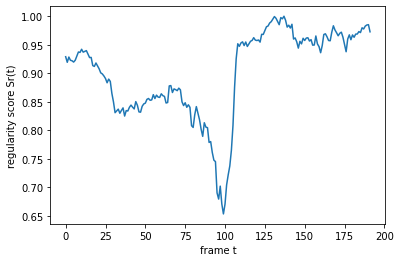

In [ ]:
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [ ]:
sequences.shape

(192, 256, 256, 1)

In [ ]:
seq_num = 100

In [ ]:
result = []
result.append(sequences[seq_num].reshape((ModelConfig.H, ModelConfig.W)))
result.append(reconstructed_sequences[seq_num].reshape((ModelConfig.H, ModelConfig.W)))
result = np.array(result)

In [ ]:
result.shape


(2, 256, 256)

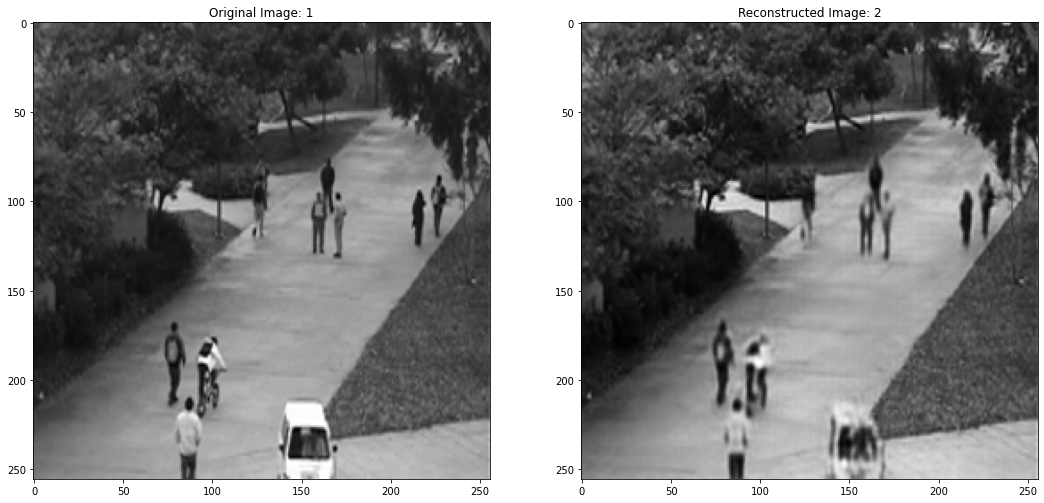

In [ ]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,20))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(result[i], cmap="gray")
    if i % 2 == 0:
      plt.title('Original Image: {}'.format(i+1))
    else:
      plt.title('Reconstructed Image: {}'.format(i+1))

plt.show()

In [ ]:
from scipy import signal
from PIL import Image

In [ ]:
def fig2data(fig):
    fig.canvas.draw ( )
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    data = data.reshape((h, w, 3))
    return data

In [ ]:
def plot(img, fig, axes,output, diff, H, threshold):
    (ax0, ax1, ax2,ax3) = axes
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1) 

    plt.axis('off')
    data = fig2data ( fig )
    return Image.fromarray(data)

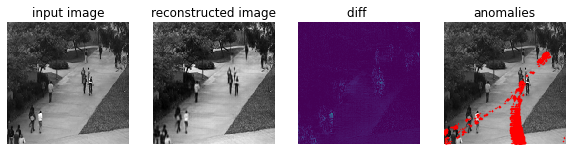

In [ ]:
threshold = 4*255
counter = 0

fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
frame_result = [] 

i = 0
for seq, rec_seq in zip(sequences, reconstructed_sequences):
    counter = counter + 1
    img = seq*255
    output = rec_seq*255
    diff = np.abs(output-img)

    tmp = diff[:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')

    res = plot(img[:,:,0], fig, (ax0, ax1, ax2,ax3), output[:,:,0], diff[:,:,0],
               H, threshold)
    
    frame_result.append(res)


In [ ]:
frame_result[0].save("frames_result.gif", save_all=True, 
                      append_images=frame_result[1:], duration=100, loop=0)